In [1]:
import pandas as pd
import subprocess
from tqdm import tqdm
from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt


/tmp/ipykernel_16474/3148608471.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Link all the precursors to their synthetase

In [2]:
precursor=pd.read_table('./../Data/Lanthi_precursor_info.tsv',sep='\t')
Proteins=pd.read_table('./../Data/Results_Lanthi_proteins.tsv',sep='\t')
Proteins['Type']=Proteins.sys_id.map(lambda x: x.split('_')[-3])
Synthetase=Proteins.loc[(Proteins.Domains.isin(['LANC_like','DUF4135|LANC_like','DUF4135|LANC_like|LANC_like','micKC','DUF4135|LANC_like|LANC_like','LANC_like|Pkinase']))]
Synthetase=Synthetase.loc[~Synthetase.Accession_DB.isna()]
Synthetase['Accession_DB']=Synthetase.Accession_DB.map(lambda x: x.replace(' ',''))

/tmp/ipykernel_16474/3730664661.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Synthetase['Accession_DB']=Synthetase.Accession_DB.map(lambda x: x.replace(' ',''))


Avoid precursor when there is also other lanthipeptide type in the AS region and Region with multiple synthetase

In [3]:
region_w_other=Synthetase.loc[Synthetase.Type!='lanthipeptide-class-i'].Region
type_I=Synthetase.loc[(Synthetase.Type=='lanthipeptide-class-i')&(~Synthetase.Region.isin(region_w_other))]
nb_region=type_I.Region.value_counts().reset_index().rename({'count':'Nb_per_region'},axis=1)
type_I=type_I.loc[type_I.Region.isin(nb_region.loc[nb_region.Nb_per_region==1].Region)]
precursor=precursor.merge(type_I[['sys_id','Accession_DB']].rename({'Accession_DB':'hit_id'},axis=1),on="sys_id")

In [4]:
precursor['ID_precursor']=precursor.hit_id+'_'+precursor.index.map(str)
precursor.loc[precursor.Core.isna()][['ID_precursor','Complete']].to_csv('./../Precursor/Blast/Precursor_no_core.tsv',sep='\t',index=False,header=False)
subprocess.run('seqkit tab2fx ./../Precursor/Blast/Precursor_no_core.tsv > ./../Precursor/Blast/Precursor_no_core.fasta',shell=True)

CompletedProcess(args='seqkit tab2fx ./../Blast/Precursor_no_core.tsv > ./../Blast/Precursor_no_core.fasta', returncode=0)

## Find the corepeptide delimitation when antismash does not find it

Blast of the full precursor against a database of core peptide from Walker et al 2020.

In [25]:
subprocess.run('blastp -db ./../Precursor/Database/Walker_predicted_core.fasta -query ./../Precursor/Blast/Precursor_no_core.fasta -evalue 1e-3 -outfmt 6 -out ./../Precursor/Blast/Blast_all_no_core.tsv',shell=True)

CompletedProcess(args='blastp -db ./../Database/Walker_predicted_core.fasta -query ./../Blast/Precursor_no_core.fasta -evalue 1e-3 -outfmt 6 -out ./../Blast/Blast_all_no_core.tsv', returncode=0)

Take only the best hit of the blast to choose the new delimitation of the corepeptide

In [5]:
blast=pd.read_table('./../Precursor/Blast/Blast_all_no_core.tsv',sep='\t',names=["ID_precursor","sseqid","pident","length","mismatch","gapopen","qstart","qend","sstart","send","evalue","bitscore"])
blast=blast.sort_values('bitscore',ascending=False).drop_duplicates('ID_precursor')
no_core=precursor.loc[precursor.Core.isna()]
no_core=no_core.merge(blast[['ID_precursor','qstart','qend']],on='ID_precursor').reset_index(drop=True)
for i in no_core.index.to_list():
    no_core.loc[i,'Core']=no_core.Complete[i][no_core.qstart[i]-1:no_core.qend[i]+1]
precursor=precursor.loc[~precursor.Core.isna()]
precursor=pd.concat([precursor,no_core.drop(columns=['qstart','qend'])])

Create a blast database with all the core peptide detected in the 29k genomes.

Blastp all the corepeptide against each others

In [27]:
precursor[['ID_precursor','Core']].to_csv('./../Precursor/Database/All_Core_precursor.tsv',sep='\t',index=False,header=False)
subprocess.run('seqkit tab2fx ./../Precursor/Database/All_Core_precursor.tsv > ./../Precursor/Database/All_Core_precursor.fasta',shell=True)
subprocess.run('makeblastdb -in ./../Precursor/Database/All_Core_precursor.fasta -dbtype prot',shell=True)
subprocess.run('blastp -db ./../Precursor/Database/All_Core_precursor.fasta -query ./../Precursor/Database/All_Core_precursor.fasta -num_threads 8 -outfmt 6 -out ./../Precursor/Blast/Blast_all_core_against_core.tsv -evalue 1e-3',shell=True)



Building a new DB, current time: 06/26/2024 13:10:35
New DB name:   /mnt/c/Users/flori/Documents/Public_data/Lanthiphage_git/Database/All_Core_precursor.fasta
New DB title:  ./../Database/All_Core_precursor.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /mnt/c/Users/flori/Documents/Public_data/Lanthiphage_git/Database/All_Core_precursor.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 2805 sequences in 0.167075 seconds.




CompletedProcess(args='blastp -db ./../Database/All_Core_precursor.fasta -query ./../Database/All_Core_precursor.fasta -num_threads 8 -outfmt 6 -out ./../Blast/Blast_all_core_against_core.tsv -evalue 1e-3', returncode=0)

## Calculation of the proximity score between all corepeptide

The score of proximity = % of identity / % of coverage

In [6]:
precursor['Length_core']=precursor.Core.map(len)
blast_core=pd.read_table('./../Precursor/Blast/Blast_all_core_against_core.tsv',sep='\t',names=["ID_precursor","sseqid","pident","length","mismatch","gapopen","qstart","qend","sstart","send","evalue","bitscore"])
blast_core
Maximum=blast_core.sort_values('bitscore',ascending=False).drop_duplicates('ID_precursor')[['ID_precursor','bitscore']].rename({'bitscore':'max_bitscore'},axis=1)
blast_core=blast_core.merge(Maximum,on='ID_precursor')
blast_core=blast_core.merge(precursor[['ID_precursor','Length_core']].drop_duplicates(),on='ID_precursor')
blast_core['Score']=blast_core.bitscore/blast_core.max_bitscore
blast_core['Score2']=blast_core.pident*blast_core.length/blast_core.Length_core
blast_core

,ID_precursor,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,max_bitscore,Length_core,Score,Score2
0,GCF_001187435.1_NZ_LFXA01000009.1_03180_0,GCF_001187435.1_NZ_LFXA01000009.1_03180_0,100.000,22,0,0,1,22,1,22,2.450000e-12,47.0,47.0,22,1.000000,100.000000
1,GCF_000308615.1_NZ_BAGB01000062.1_03551_1,GCF_000308615.1_NZ_BAGB01000062.1_03551_1,100.000,25,0,0,1,25,1,25,4.080000e-15,53.9,53.9,25,1.000000,100.000000
2,GCF_900119365.1_NZ_FPJO01000006.1_04707_2,GCF_900119365.1_NZ_FPJO01000006.1_04707_2,100.000,23,0,0,1,23,1,23,5.990000e-13,48.5,48.5,23,1.000000,100.000000
3,GCF_900119365.1_NZ_FPJO01000006.1_04707_2,GCF_026341295.1_NZ_JAPEOM010000001.1_01991_1832,62.500,24,7,1,2,23,13,36,8.690000e-05,28.1,48.5,23,0.579381,65.217391
4,GCF_900119365.1_NZ_FPJO01000006.1_04707_2,GCF_026343375.1_NZ_JAPELV010000001.1_08298_1831,62.500,24,7,1,2,23,13,36,8.690000e-05,28.1,48.5,23,0.579381,65.217391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652692,GCF_016786345.1_NZ_JADWYT010000086.1_00936_2814,GCF_000377605.1_NZ_KB898435.1_01037_2339,63.158,19,7,0,1,19,1,19,2.770000e-04,26.6,44.3,24,0.600451,50.000083
652693,GCF_016786345.1_NZ_JADWYT010000086.1_00936_2814,GCF_001983215.1_NZ_MOWP01000013.1_06530_2559,63.158,19,7,0,1,19,1,19,3.880000e-04,26.2,44.3,24,0.591422,50.000083
652694,GCF_016786345.1_NZ_JADWYT010000086.1_00936_2814,GCF_020991275.1_NZ_JAJLQY010000001.1_03425_2780,68.421,19,6,0,1,19,2,20,6.670000e-04,25.4,44.3,24,0.573363,54.166625
652695,GCF_016786345.1_NZ_JADWYT010000086.1_00936_2814,GCF_000484695.1_NZ_AXVR01000064.1_01592_2457,57.895,19,8,0,1,19,1,19,6.850000e-04,25.4,44.3,24,0.573363,45.833542


Averaging the proximity score between the pairs of precursor and create a symetric similarity matrix.

In [8]:
blast_core['Combo_list']=blast_core.ID_precursor+"|"+blast_core.sseqid
blast_core['Combo_list']=blast_core.Combo_list.map(lambda x: x.split('|'))
blast_core['Combo_list']=blast_core.Combo_list.map(lambda x: sorted(x))
blast_core['Combo']=blast_core.Combo_list.map(lambda x: "|".join(x))

blast_core=blast_core.merge(blast_core.groupby('Combo').Score2.mean().to_frame().reset_index().rename({'Score2':'Score_mean'},axis=1),on='Combo')


blast_core['Score_min']=blast_core.Score_mean
blast_core.loc[blast_core.Score_mean<0.4, 'Score_min']=0
A=blast_core.loc[blast_core.sseqid!=blast_core.ID_precursor].Combo.value_counts().reset_index().rename({'count':'Nb_combo'},axis=1)
A=A.loc[A.Nb_combo==1]
blast_core=blast_core.loc[~blast_core.Combo.isin(A.loc[A.Nb_combo==1].Combo)]

blast_wide=blast_core.pivot_table(index='ID_precursor',columns=['sseqid'],values='Score_min',aggfunc=sum).fillna(0)


/tmp/ipykernel_16474/1411116115.py:15: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  blast_wide=blast_core.pivot_table(index='ID_precursor',columns=['sseqid'],values='Score_min',aggfunc=sum).fillna(0)


## Creation of the community

Creation of community using the Louvain methods

In [9]:
G =nx.from_pandas_adjacency(blast_wide)
Communities=pd.DataFrame.from_dict({"Community": community_louvain.best_partition(G,random_state=42)})
Communities

,Community
GCF_000010605.1_NC_010572.1_03779_1026,0
GCF_000013345.1_NC_007777.1_01119_1312,18
GCF_000013345.1_NC_007777.1_01820_871,18
GCF_000013345.1_NC_007777.1_02025_530,18
GCF_000013345.1_NC_007777.1_03300_2437,0
...,...
GCF_937891335.1_NZ_CALAGC010000104.1_00399_830,0
GCF_947488945.1_NZ_CANLBS010000002.1_00268_183,2
GCF_947494875.1_NZ_CANLWM010000004.1_04113_1230,12
GCF_947533635.1_NZ_CANNXG010000017.1_01919_2040,12


Creation of subcommunity by reusing exactly the same method for each community defined in the previous step

In [10]:
Communities['Subcommunity']=0
Subcommunity=pd.DataFrame({'ID_precursor':[],'Community':[],'Subcommunity':[]})
for i in tqdm(Communities.Community.unique()):
    G =nx.from_pandas_adjacency(blast_wide.loc[Communities.loc[Communities.Community==i].index][Communities.loc[Communities.Community==i].index])
    Subcommunity_tmp=pd.DataFrame.from_dict({"SubCommunity": community_louvain.best_partition(G,random_state=42)})
    Subcommunity_tmp=pd.DataFrame({'ID_precursor':Subcommunity_tmp.index,'Community':[i for x in range(len(Subcommunity_tmp))],'Subcommunity':Subcommunity_tmp.SubCommunity})
    Subcommunity=pd.concat([Subcommunity,Subcommunity_tmp])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:04<00:00, 28.50it/s]


In [13]:
Subcommunity['Combo_Subcommunity']=Subcommunity.Community.map(str)+"_"+Subcommunity.Subcommunity.map(str)

In [14]:
Subcommunity=Subcommunity.merge(precursor[['ID_precursor','Core']],on='ID_precursor')

For all subcommunity, create a fasta file and an alignment using mafft

In [ ]:
List_community=Subcommunity.Combo_Subcommunity.value_counts().index
Alignment=pd.DataFrame({'ID_precursor':[],'Align':[]})
for i in tqdm(List_community):
    tmp=Subcommunity.loc[Subcommunity.Combo_Subcommunity==i][['ID_precursor','Core']]
    tmp.to_csv('./../Precursor/tmp',sep='\t',index=False,header=False)
    subprocess.run('seqkit tab2fx ./../Precursor/tmp > ./../Precursor/Brut_all/Community_'+str(i)+'.fasta',shell=True,stderr=subprocess.DEVNULL,stdout=subprocess.DEVNULL)
    if len(tmp)>1:
        subprocess.run('mafft --auto --reorder ./../Precursor/Brut_all/Community_'+str(i)+".fasta > ./../Precursor/Align_all/Community_"+str(i)+".fasta",shell=True,stderr=subprocess.DEVNULL,stdout=subprocess.DEVNULL)
    else:
        subprocess.run('cp  ./../Precursor/Brut_all/Community_'+str(i)+".fasta  ./../Precursor/Align_all/Community_"+str(i)+".fasta",shell=True,stderr=subprocess.DEVNULL,stdout=subprocess.DEVNULL)

    subprocess.run('seqkit fx2tab ./../Precursor/Align_all/Community_'+str(i)+'.fasta > ./../Precursor/Align_all/Community_'+str(i)+'.tsv',shell=True,stderr=subprocess.DEVNULL,stdout=subprocess.DEVNULL)
    tmp=pd.read_table('./../Precursor/Align_all/Community_'+str(i)+".tsv",sep='\t',names=['ID_precursor','Align','X']).drop(columns=['X'])
    Alignment=pd.concat([Alignment,tmp])

Retrieve the order of all sequences after alignment and sort the table

In [15]:
subprocess.run('grep ">" ./../Precursor/Align_all/Community_*.fasta |awk -F " " '+" '{print $1}' | awk -F '/' '{print $NF}' | sed 's/.fasta:>/ /g' > ./../Precursor/Precursor_order_all.tsv ",shell=True)
order_Precursor=pd.read_table('./../Precursor/Precursor_order_all.tsv',sep=' ',names=['Combo_Subcommunity','ID_precursor'])
# blast_wide_ordered_align=blast_wide.loc[order_Precursor.ID_precursor,order_Precursor.ID_precursor]
order_Precursor['Order']=order_Precursor.index
Subcommunity=Subcommunity.merge(order_Precursor[['ID_precursor','Order']],on='ID_precursor',how='left').fillna(0).sort_values(['Combo_Subcommunity','Order'])

Add color depending on if this a defensive lanthipeptide or not

In [18]:
defensive=pd.read_table('./../Data/Results_01_Defense_and_MGE.tsv',sep='\t')
defensive.loc[defensive.New_clade!='Non Defensive','Color']='#A57E7E'
defensive.loc[defensive.New_clade=='Non Defensive','Color']='#CDCBCB'
Subcommunity['Accession_DB']=Subcommunity.ID_precursor.map(lambda x: "_".join(x.split('_')[:-1]))
Subcommunity.merge(defensive,on='Accession_DB').Color

0       #A57E7E
1       #A57E7E
2       #A57E7E
3       #A57E7E
4       #A57E7E
         ...   
2754    #CDCBCB
2755    #A57E7E
2756    #A57E7E
2757    #CDCBCB
2758    #A57E7E
Name: Color, Length: 2759, dtype: object

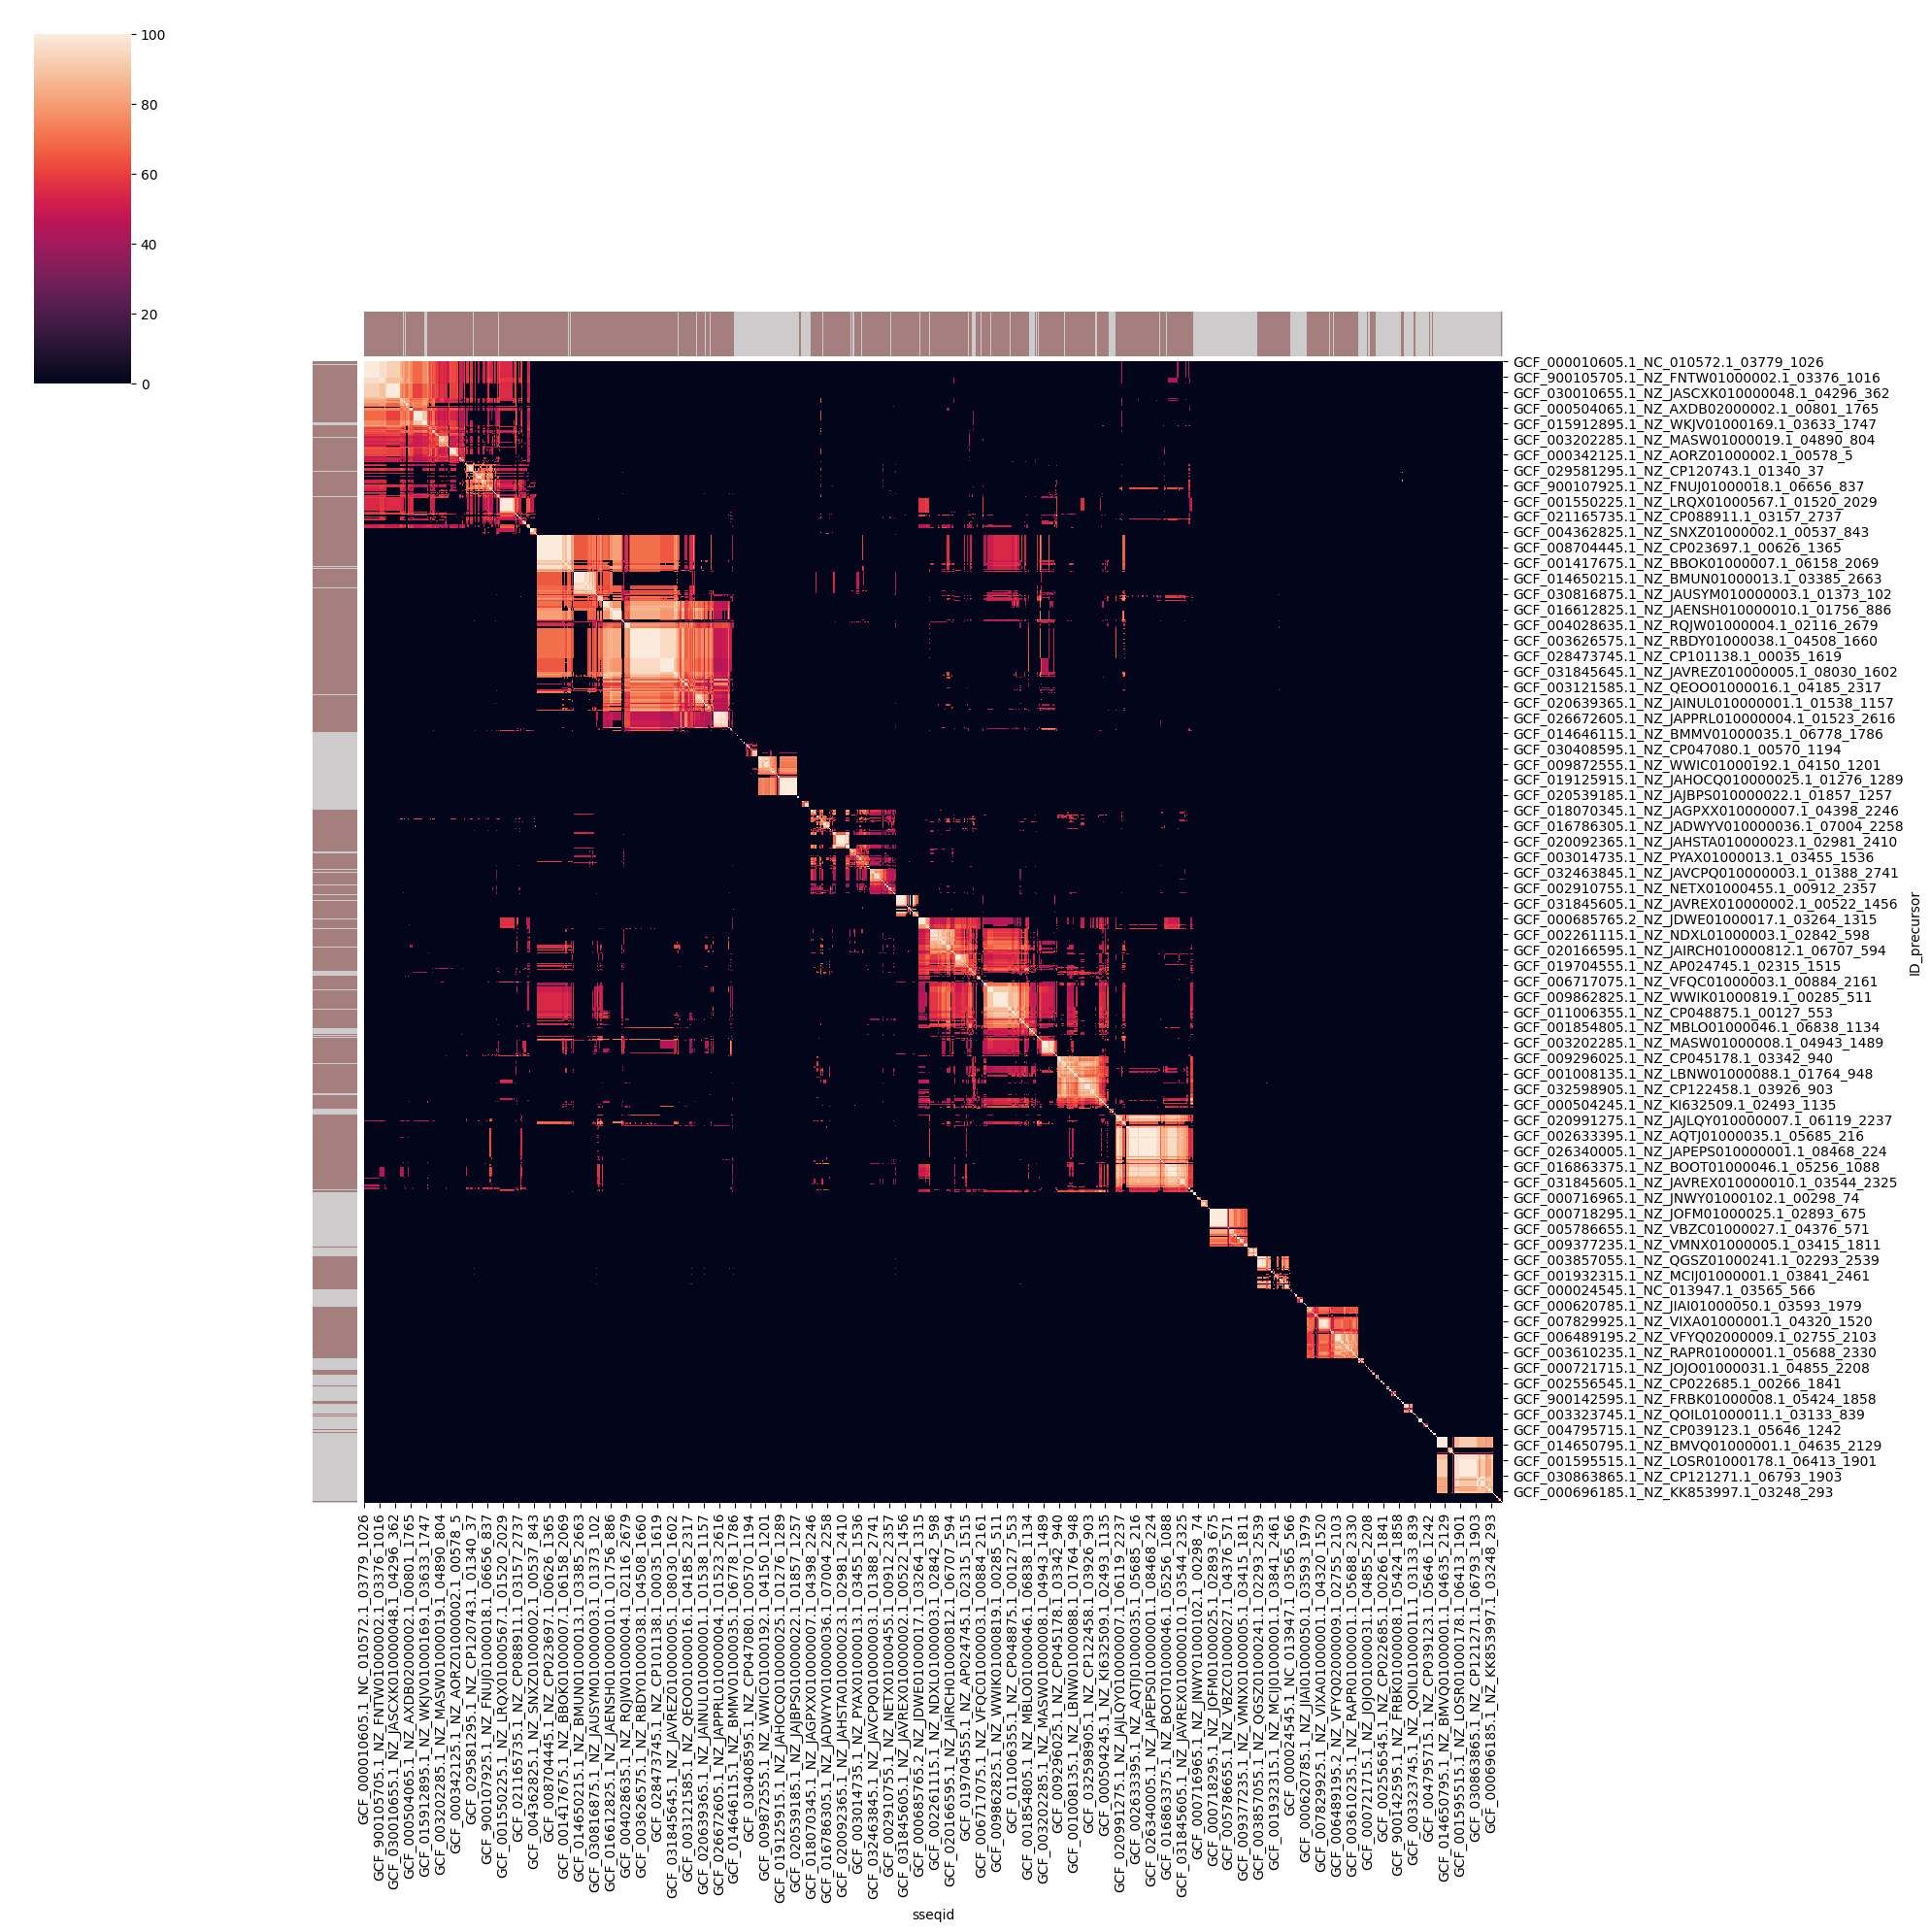

In [19]:

blast_wide_ordered_align=blast_wide.loc[Subcommunity.ID_precursor,Subcommunity.ID_precursor]

sns.clustermap(blast_wide_ordered_align,col_cluster=False,row_cluster=False,figsize=(20,20),
               row_colors=Subcommunity.merge(defensive,on='Accession_DB',how='left').fillna('#CDCBCB').Color.to_list(),
               col_colors=Subcommunity.merge(defensive,on='Accession_DB',how='left').fillna('#CDCBCB').Color.to_list())

In [20]:
Precursors_all_info=Subcommunity.merge(defensive,on='Accession_DB')

In [22]:
Precursors_all_info.loc[Precursors_all_info.New_clade!='Non Defensive'].groupby('New_clade').Accession_DB.value_counts().to_frame().rename({'count':'Nb'},axis=1).reset_index().groupby('New_clade').Nb.value_counts()

New_clade  Nb
Clade 1    1     237
           2       1
Clade 10   1     336
           2       5
Clade 2    1     164
           2       1
Clade 3    1     107
Clade 4    1     141
           2       1
Clade 5    1     233
           2       6
Clade 6    1      83
           2       1
Clade 7    1     215
           2       2
Clade 8    1     165
Clade 9    1      47
           3      42
           2      30
Limit      1       5
           2       1
Other      1      32
Name: count, dtype: int64

In [23]:
Precursors_all_info.loc[Precursors_all_info.New_clade!='Non Defensive'].Accession_DB.value_counts().value_counts()

count
1    1765
2      48
3      42
Name: count, dtype: int64

In [24]:
classif_precur=pd.read_table('./../Data/Classification_Precursor_manual.tsv',sep='\t')
classif_precur=classif_precur.merge(Precursors_all_info,left_on='Precursor_ID',right_on='ID_precursor')

In [26]:
classif_precur.columns
# classif_precur=classif_precur.drop(columns=['Community_y','Clade_y']).rename({'Community_x':'Community','Clade_x':'Clade'},axis=1)
classif_precur.to_csv('./../Data/Supp_table_precursor.tsv',sep='\t')
classif_precur.merge(precursor[['ID_precursor','Complete']].rename({'ID_precursor':'Precursor_ID'},axis=1),on='Precursor_ID').to_csv('./../Data/Supp_table_precursor.tsv',sep='\t',index=False)

In [27]:
classif_precur

,Community_x,Precursor_ID,Sequence,Synthetase,Clade,New Type,Previous type,XP validation,name,ID_precursor,...,New_clade,Type_defensive,Done_sys,Sys_close,Nb_sys_close,Close_type,Close_sys_id,In_plasmid,Close_conservon,Color
0,0.0_1.0,GCF_015767755.1_NZ_CP065248.1_01971_2808,AEHPYGKLMCSTGDGCGPTCQGGASACNSFVEDS,GCF_015767755.1_NZ_CP065248.1_01971,Clade_9.1,Type 1,1,0,0,GCF_015767755.1_NZ_CP065248.1_01971_2808,...,Clade 1,Lanthiphage,0,1.0,1.0,CBASS_II,GCF_015767755.1_CBASS_II_7,0,0.0,#A57E7E
1,0.0_1.0,GCF_028752555.1_NZ_CP086229.1_04270_2802,AEHPYGKLMCSTGDGCGPTCQGGASACNSFVEDS,GCF_028752555.1_NZ_CP086229.1_04270,Clade_9.1,Type 1,1,0,0,GCF_028752555.1_NZ_CP086229.1_04270_2802,...,Clade 1,Lanthiphage,0,1.0,1.0,CBASS_II,GCF_028752555.1_CBASS_II_8,0,0.0,#A57E7E
2,10.0_1.0,GCF_025165795.1_NZ_JAJAGO010000021.1_02833_2811,DGFELDVALLEVADTAGLINLTDDGCGETCGACTTNVA,GCF_025165795.1_NZ_JAJAGO010000021.1_02833,Clade_4,Type 6,6,0,0,GCF_025165795.1_NZ_JAJAGO010000021.1_02833_2811,...,Clade 10,Lanthiphage,0,0.0,NaN,NaN,NaN,0,0.0,#A57E7E
3,14.0_0.0,GCF_029958285.1_NZ_JASBOE010000018.1_04036_2805,MATATAPLTTTTVEAPLSDEWELDTTITRSPAPIVEACDTNDGCAS...,GCF_029958285.1_NZ_JASBOE010000018.1_04036,Clade_1,Type 8,8,0,0,GCF_029958285.1_NZ_JASBOE010000018.1_04036_2805,...,Clade 7,Lanthiphage,0,0.0,NaN,NaN,NaN,0,0.0,#A57E7E
4,14.0_0.0,GCF_020092085.1_NZ_JAHSTP010000004.1_01080_2806,PRPAAAVAEPLPAEEWELDTTVTRAPVPIVEACGTGDGCAKTCASS...,GCF_020092085.1_NZ_JAHSTP010000004.1_01080,Clade_1,Type 8,8,0,0,GCF_020092085.1_NZ_JAHSTP010000004.1_01080_2806,...,Clade 7,Lanthiphage,0,1.0,1.0,CAS_Class1-Subtype-I-E,GCF_020092085.1_CAS_Class1-Subtype-I-E_9,0,0.0,#A57E7E
5,14.0_1.0,GCF_024701375.2_NZ_CP113910.1_02838_2809,DLLPKACGTGDGCAASCASSCASAV,GCF_024701375.2_NZ_CP113910.1_02838,Clade_1,Type 8,6,0,0,GCF_024701375.2_NZ_CP113910.1_02838_2809,...,Clade 7,Lanthiphage,0,1.0,1.0,RM_Type_I,GCF_024701375.2_RM_Type_I_13,0,0.0,#A57E7E
6,18.0_0.0,GCF_033097365.1_NZ_AP028461.1_08696_2813,VDHIIKMTNDGCGSTCQSACTSC,GCF_033097365.1_NZ_AP028461.1_08696,Clade_7,Type 2,2,0,0,GCF_033097365.1_NZ_AP028461.1_08696_2813,...,Clade 5,Lanthiphage,0,1.0,1.0,Dpd,GCF_033097365.1_Dpd_8,0,0.0,#A57E7E
7,2.0_2.0,GCF_002551045.1_NZ_NTGO01000003.1_07454_2812,ATETVLMCGTGDNCGSSCPSACTTS,GCF_002551045.1_NZ_NTGO01000003.1_07454,Clade_2,Type 3,3,0,0,GCF_002551045.1_NZ_NTGO01000003.1_07454_2812,...,Clade 8,Lanthiphage,0,0.0,NaN,NaN,NaN,1,0.0,#A57E7E
8,25.0_0.0,GCF_000308615.1_NZ_BAGB01000062.1_03551_1,YSTFAMCSAVSCPNGPSCLPCEQRR,GCF_000308615.1_NZ_BAGB01000062.1_03551,NaN,NaN,NaN,NaN,NaN,GCF_000308615.1_NZ_BAGB01000062.1_03551_1,...,Non Defensive,lanthipeptide-class-i,0,0.0,NaN,NaN,NaN,0,0.0,#CDCBCB
9,29.0_0.0,GCF_029626265.1_NZ_JARUBN010000001.1_03638_2803,LADTDDGCDTVKGSDC,GCF_029626265.1_NZ_JARUBN010000001.1_03638,Clade_5,Type 5,5,0,0,GCF_029626265.1_NZ_JARUBN010000001.1_03638_2803,...,Clade 6,Lanthiphage,0,1.0,1.0,Wadjet_II,GCF_029626265.1_Wadjet_II_6,0,0.0,#A57E7E
